In [1]:
%pip install tensorflow==2.12


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import os
import time

2024-12-29 21:20:15.993034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.__version__

'2.12.0'

### SOURCE TEXT LOADING
- loading .txt
- printing the beginning, number of characters, number of unique characters
    

In [4]:
with open("ring.txt", "r", encoding="utf-8") as f:
    source = f.read()
print(type(source))
print(source[:200])


<class 'str'>
THE  FELLOWSHIP 
OF  THE  RING 


BEING  THE  FIRST  PART 
OF 

The  Lord  of  the  Rings 


BOOK  ONE 


Chapter  I 


A  LONG-EXPECTED  PARTY 


When  Mr.  Bilbo  Baggins  of  Bag  End  announced  t


In [5]:
print (f"{len(source)} characters")

1145534 characters


In [6]:
vocab = sorted(set(source))
print (f"{len(vocab)} unique characters")

88 unique characters


In [7]:
# unique characters to indices mapping
char2index = {u: i for i, u in enumerate(vocab)}
index2char = np.array(vocab)

text_as_int = np.array([char2index[c] for c in source])

print(text_as_int)

[45 33 30 ...  1  0  0]


In [8]:
print (f"{repr(source[:13])} -- characters mapped to int -- > {text_as_int[:13]}")

'THE  FELLOWSH' -- characters mapped to int -- > [45 33 30  1  1 31 30 37 37 40 48 44 33]


### DATASET PREPROCESSING
- character to index mapping and converting text to numerical representation
- defining max input sequence length
- creating TensorFlow Dataset from the source
- creating batches from dataset
- input-target split function (:-1 is input, and last element is expected value)
- applying input-target split function to each batch

In [9]:
seq_length = 100
examples_per_epoch = len(source)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(index2char[i.numpy()])


2024-12-29 21:20:21.888311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-29 21:20:21.958125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-29 21:20:21.958553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


T
H
E
 
 


2024-12-29 21:20:21.962747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-29 21:20:21.963481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-29 21:20:21.964050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-29 21:20:22.288446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-29 21:20:22.289116: I tensorflow/compile

In [10]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'THE  FELLOWSHIP \nOF  THE  RING \n\n\nBEING  THE  FIRST  PART \nOF \n\nThe  Lord  of  the  Rings \n\n\nBOOK  ON'
'E \n\n\nChapter  I \n\n\nA  LONG-EXPECTED  PARTY \n\n\nWhen  Mr.  Bilbo  Baggins  of  Bag  End  announced  tha'
't  he \nwould  shortly  be  celebrating  his  eleventy-first  birthday  with \na  party  of  special  m'
'agnificence,  there  was  much  talk  and \nexcitement  in  Hobbiton. \n\nBilbo  was  very  rich  and  v'
'ery  peculiar,  and  had  been  the \nwonder  of  the  Shire  for  sixty  years,  ever  since  his  re'


2024-12-29 21:20:22.750206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]


In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### PARAMETERS
- training parameters & data shuffling
- model hyperparameters

In [12]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(1024, 100), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 100), dtype=tf.int64, name=None))>

In [13]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 300 #256

# Number of RNN units
rnn_units1 = 256
rnn_units2 = 256
rnn_units=[rnn_units1, rnn_units2]
print(vocab_size)

88


### BUILDING MODEL
- GRU, LSTM, RNN, with Conv1

In [14]:
# # ORIGINAL GRU
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#   model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                               batch_input_shape=[batch_size, None]),
#     tf.keras.layers.GRU(rnn_units1,
#                         return_sequences=True,
#                         stateful=True,
#                         recurrent_initializer='glorot_uniform'),
#     tf.keras.layers.GRU(rnn_units2,
#                         return_sequences=True,
#                         stateful=True,
#                         recurrent_initializer='glorot_uniform'),
#     tf.keras.layers.Dense(vocab_size)
#   ])
#   return model

In [15]:
# LSTM
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units1,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units2,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [16]:
# # RNN
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.SimpleRNN(rnn_units1,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.SimpleRNN(rnn_units2,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [17]:
# # dodanie Conv1
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.Conv1D(filters=128,
#                                kernel_size=5,
#                                activation='relu',
#                                padding='same'),
#         tf.keras.layers.GRU(rnn_units1,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.GRU(rnn_units2,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [18]:
model = build_model(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

2024-12-29 21:20:23.268138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-29 21:20:23.273402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-29 21:20:23.277031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1024, None, 300)         26400     
                                                                 
 lstm (LSTM)                 (1024, None, 256)         570368    
                                                                 
 lstm_1 (LSTM)               (1024, None, 256)         525312    
                                                                 
 dense (Dense)               (1024, None, 88)          22616     
                                                                 
Total params: 1,144,696
Trainable params: 1,144,696
Non-trainable params: 0
_________________________________________________________________


### MODEL TRAINING
- optimizer & loss function declaration
- compilation
- epochs number
- launching the training

In [20]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [21]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [22]:
checkpoint_dir = './checkpoints_LSTM'        # TODO: remember to choose proper directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [23]:
EPOCHS=200

In [26]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200


2024-12-29 21:20:29.541388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]
2024-12-29 21:20:29.541873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]
2024-12-29 21:20:29.823735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

11/11 [==============================] - 23s 1s/step - loss: 3.6112 - accuracy: 0.2755
Epoch 2/200
11/11 [==============================] - 16s 1s/step - loss: 2.9202 - accuracy: 0.3008
Epoch 3/200
11/11 [==============================] - 15s 1s/step - loss: 2.8871 - accuracy: 0.3008
Epoch 4/200
11/11 [==============================] - 15s 1s/step - loss: 2.8769 - accuracy: 0.3008
Epoch 5/200
11/11 [==============================] - 16s 1s/step - loss: 2.8686 - accuracy: 0.3008
Epoch 6/200
11/11 [==============================] - 15s 1s/step - loss: 2.8487 - accuracy: 0.3008
Epoch 7/200
11/11 [==============================] - 16s 1s/step - loss: 2.7702 - accuracy: 0.3036
Epoch 8/200
11/11 [==============================] - 17s 1s/step - loss: 2.5941 - accuracy: 0.3308
Epoch 9/200
11/11 [==============================] - 17s 1s/step - loss: 2.4710 - accuracy: 0.3580
Epoch 10/200
11/11 [==============================] - 17s 1s/step - loss: 2.3966 - accuracy: 0.3671
Epoch 11/200
11/11 [=

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1024, None, 300)         26400     
                                                                 
 lstm (LSTM)                 (1024, None, 256)         570368    
                                                                 
 lstm_1 (LSTM)               (1024, None, 256)         525312    
                                                                 
 dense (Dense)               (1024, None, 88)          22616     
                                                                 
Total params: 1,144,696
Trainable params: 1,144,696
Non-trainable params: 0
_________________________________________________________________


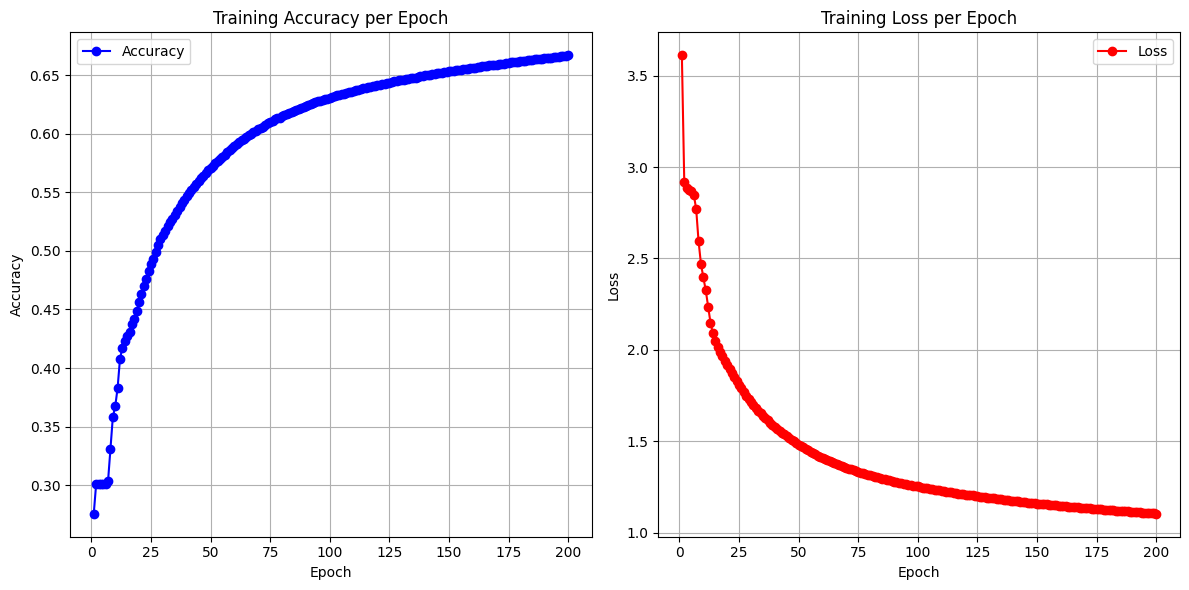

In [29]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Wykres strat i dokładności
plt.figure(figsize=(12, 6))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

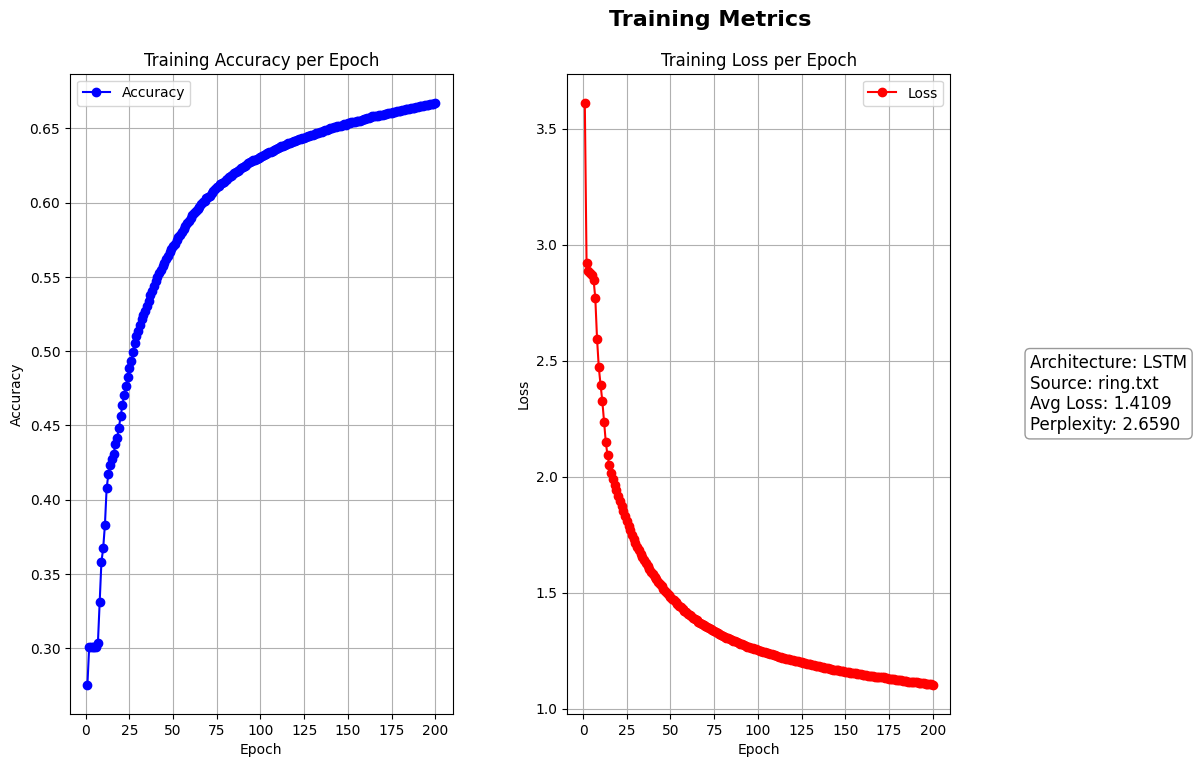

In [30]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Informacje do wyświetlenia
architecture = "LSTM"
source_text = "ring.txt"
avg_loss = sum(loss) / len(loss)  # Średnia strat
perplexity = 2 ** avg_loss  # Przykład obliczenia perplexity
info_text = f"Architecture: {architecture}\nSource: {source_text}\nAvg Loss: {avg_loss:.4f}\nPerplexity: {perplexity:.4f}"

# Tworzenie figury i wykresów
fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3})

# Tytuł na środku
fig.suptitle("Training Metrics", fontsize=16, fontweight='bold')

# Wykres dokładności
axes[0].plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
axes[0].set_title('Training Accuracy per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

# Wykres strat
axes[1].plot(epochs, loss, marker='o', label='Loss', color='red')
axes[1].set_title('Training Loss per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

# Dodanie informacji w pustej przestrzeni (poza wykresami)
fig.text(0.7, 0.5, info_text, fontsize=12, va='center', ha='left',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle="round"))

# Dostosowanie marginesów, aby uniknąć nachodzenia
plt.subplots_adjust(left=0.1, right=0.65, top=0.9, bottom=0.1)

# Wyświetlanie wykresu
plt.show()

### RESULTS
- bulding the model and applying saved weights
- text generation function
- generate text based on the provided beginning

In [31]:
latest_check= tf.train.latest_checkpoint(checkpoint_dir)

In [32]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(latest_check)

model.build(tf.TensorShape([1, None]))

2024-12-29 22:32:16.978817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-29 22:32:16.984867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-29 22:32:16.987199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 300)            26400     
                                                                 
 lstm_2 (LSTM)               (1, None, 256)            570368    
                                                                 
 lstm_3 (LSTM)               (1, None, 256)            525312    
                                                                 
 dense_1 (Dense)             (1, None, 88)             22616     
                                                                 
Total params: 1,144,696
Trainable params: 1,144,696
Non-trainable params: 0
_________________________________________________________________


In [35]:
def generate_text(model, start_string):

  num_generate = 1000
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  scaling = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / scaling
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [36]:
print(generate_text(model, start_string=u"Bilbo destroyed the Ring "))

Bilbo destroyed the Ring  in  the  shore.  He  had  fallen  and  before  them 
to  the  far  far  from  the  words  for  the  sound  that  was  some  starts  of  his  fire, 
and  the  dark  shore  of  the  hall  before  here  to  the  noise, 
and  then  he  was  said  and  dropping  the  memory  of  the  story  and  have  been  seen 
to  come  to  the  hobbits  of  Baggins.  The  sky  was  strong  and  the  stars  of 
the  stars,  and  the  pace  of  the  hills  and  that  had  seen  in  the  steep  of  the  hill  of  the  refleash  before  them.  They 
saw  the  windows  remained  that  the  great  mountains  of 
the  Ring  with  the  hobbits  of  the  wild  and  stone  and 
thinking  of  the  shadows  of  the  fallen  under  the  top  of  the  lands  of  the  wall,  but  the 
land  was  stone  to  the  story  were  the  stream 
of  Men  of  a  horse  was  now  longer  in  the  Shire,  and  so  suddenly 
all  to  see  the  water  of  the  sound  of  the  world. 

The  land  was  botte

In [37]:
print(generate_text(model, start_string=u"Bilbo killed Gandal "))

Bilbo killed Gandal C]O(L0Y80NRGG]EG^^4§2&2zR^]—PXN0Q“^^—ZE1Y—ORHRY7HO&]7^]63‘-5Lv]3]TxPqHHU02&]QALXT§Xp0]]^050UG211—L—K^]5K7XL&N]5—R0Xq§656RZ§LGq)5vy“§RREzL002]k“XRAQEXR83&4UL&LE0ZH§O&60"0"LX8XX"^“^RQW4§YR50—A9(HR2H(4UR5G“^Q5—E089G5^3U2“0PRHO5240\\2E8&“q-2“4BW"2x2U977313


they  will  be  seen  of  the  desere  of  the  world.  ‘I  have  left  the  falls  of  the  house,  and  they  were  some 
that  looked  and  could  seems  that  when  they  were  a  few  waters  and  slopes  of  the  accountless  with  his 
spoke,  and  then  they  are  a  great  power  of  a  sound  of  the  water.  The  silver  was  still  rising.  ‘I  don’t  not  want 
to  mist  me  of  a  way,  and  there  was  a  road 
began  to  this  large  and  strange  from  the  stars  of  the  Elves  and  the 
strangers,  and  they  had  told  the  stars  had 
still  and  the  hobbits  came  out  of  the  friends  of  the  hobbits,  and  they  had  still  a  trees  and  strange  flowing  back  the  middle  of  the  star

In [38]:
def calculate_cross_entropy_loss(model, test_sequences):
    total_loss = 0
    total_steps = 0

    for sequence in test_sequences:
        input_seq = sequence[:-1]
        target_seq = sequence[1:]

        input_seq = tf.expand_dims(input_seq, 0)

        predictions = model(input_seq)

        loss = tf.keras.losses.sparse_categorical_crossentropy(target_seq, predictions[0], from_logits=True)

        total_loss += tf.reduce_sum(loss).numpy()
        total_steps += len(target_seq)

    avg_loss = total_loss / total_steps
    return avg_loss

In [39]:
# tutaj można załadować inną część tolkiena albo hobbita
first_10_sequences = list(sequences.take(2))

2024-12-29 22:35:34.959181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]


In [40]:
avg_loss = calculate_cross_entropy_loss(model, first_10_sequences)
avg_loss

0.9843720626831055

In [41]:
perplexity = np.exp(avg_loss)
perplexity

2.676130914238386